In [5]:
!pip install torchtext==0.11.2
#!pip install torchdata==0.3.0
#!pip install torch
#!pip install spellchecker
#!pip install pyspellchecker
#!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 7.2 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x399ec000 @  0x7fe4d2192615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 1.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does n

In [6]:
import torchtext
import torch
import pandas as pd
import numpy as np
import nltk
#import preprocessing
from sklearn.model_selection import train_test_split

In [7]:
# From https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

df_clean = pd.read_csv("sample_data_clean.csv")
df_clean.rename(columns={'toxic_any': 'label'}, inplace=True)
df_clean = df_clean[['label', 'clean_text']]

df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=23)
df_train, df_valid = train_test_split(df_train, test_size=0.5, random_state=23)
df_train.reset_index(inplace=True)
df_valid.reset_index(inplace=True)
df_test.reset_index(inplace=True)

df_train.drop(columns=['index'], inplace=True)
df_valid.drop(columns=['index'], inplace=True)
df_test.drop(columns=['index'], inplace=True)

df_train.to_csv('train.csv', index=False)
df_valid.to_csv('valid.csv', index=False)
df_test.to_csv('test.csv', index=False)

In [8]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('clean_text', text_field)]
device = None

train, valid, test = TabularDataset.splits(path = './',
                                    train='train.csv', 
                                    validation='valid.csv',
                                    test='test.csv',
                                    format='CSV',
                                    fields=fields, 
                                    skip_header=True)

In [9]:
# Iterators
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.clean_text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.clean_text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.clean_text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary
text_field.build_vocab(train, min_freq=3)

In [10]:
text_field.vocab.itos[0]

'<unk>'

In [11]:
dir(text_field.vocab)

['UNK',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_default_unk_index',
 'extend',
 'freqs',
 'itos',
 'load_vectors',
 'lookup_indices',
 'set_vectors',
 'stoi',
 'unk_index',
 'vectors']

In [27]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)
        print('text_emb', text_emb.shape)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        print('packed input', packed_input[0].shape, packed_input[1].shape)
        packed_output, _ = self.lstm(packed_input)
        print('packed output', packed_output[0].shape, packed_output[1].shape)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        print('output', output.shape)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        print('out_forward dim', out_forward.shape)
        out_reverse = output[:, 0, self.dimension:]
        print('out_reverse dim', out_reverse.shape)

        out_reduced = torch.cat((out_forward, out_reverse), 1)
        print('out_reduced', out_reduced.shape)
        text_fea = self.drop(out_reduced)
        print('text_fea', text_fea.shape)

        text_fea = self.fc(text_fea)
        print('text_fea2', text_fea.shape)
        text_fea = torch.squeeze(text_fea, 1)
        print('text_fea2', text_fea.shape)
        text_out = torch.sigmoid(text_fea)
        print('text_out', text_out.shape)

        return text_out

In [28]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [29]:
import torch.optim as optim

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = './',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    # training loop
    model.train()
    for epoch in range(num_epochs):
      #[('toxic_any', label_field), ('comment_text', text_field)]
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            output = model(text, text_len)
            break

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      output = model(text, text_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

text_emb torch.Size([32, 3, 300])
packed input torch.Size([72, 300]) torch.Size([3])
packed output torch.Size([72, 256]) torch.Size([3])
output torch.Size([32, 3, 256])
out_forward dim torch.Size([32, 128])
out_reverse dim torch.Size([32, 128])
out_reduced torch.Size([32, 256])
text_fea torch.Size([32, 256])
text_fea2 torch.Size([32, 1])
text_fea2 torch.Size([32])
text_out torch.Size([32])
text_emb torch.Size([32, 3, 300])
packed input torch.Size([72, 300]) torch.Size([3])
packed output torch.Size([72, 256]) torch.Size([3])
output torch.Size([32, 3, 256])
out_forward dim torch.Size([32, 128])
out_reverse dim torch.Size([32, 128])
out_reduced torch.Size([32, 256])
text_fea torch.Size([32, 256])
text_fea2 torch.Size([32, 1])
text_fea2 torch.Size([32])
text_out torch.Size([32])
text_emb torch.Size([32, 3, 300])
packed input torch.Size([72, 300]) torch.Size([3])
packed output torch.Size([72, 256]) torch.Size([3])
output torch.Size([32, 3, 256])
out_forward dim torch.Size([32, 128])
out_rev

Model loaded from <== metrics.pt


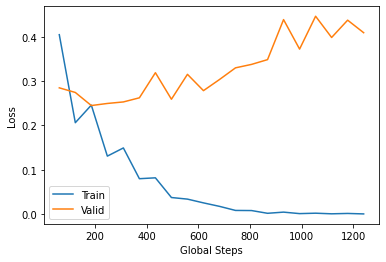

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

train_loss_list, valid_loss_list, global_steps_list = load_metrics('metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
# Evaluation Function
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:    
            print("labels are", labels)
            print("text is", text)
            print("the word in vocab is", text_field.vocab.itos[text])
            print("text len is", text_len)       
            labels = labels.to(device)
            text = text.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    #print('Classification Report:')
    print(y_true)
    print(y_pred)
    #print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Toxic', 'Non toxic'])
    ax.yaxis.set_ticklabels(['Toxic', 'Non toxic'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Model loaded from <== model.pt
labels are tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
text is tensor([[   0,    0, 4786],
        [ 393,  774,    0],
        [2206, 1286,    0],
        [ 162,  865, 3523],
        [4230,   13,    0],
        [   0,  981,  270],
        [ 140,   45,  372],
        [3150,    0,  140],
        [ 513,    0, 2716],
        [ 244, 1179,  164],
        [   0,  997,   53],
        [   0,   91,  561],
        [ 162, 1281,  122],
        [  66,    9,   31],
        [   2, 2102, 5191],
        [   0,  103,    0],
        [ 103, 2043,   45],
        [   3,  237,   45],
        [ 513,   45,   57],
        [6315, 3433,    0],
        [   8,    0, 6245],
        [ 656,  164,    0],
        [1079,    3,    1],
        [2526, 2550,    1],
        [ 172,  490,    1],
        [ 245,    0,    1],
        [ 561,  164,    1],
        [   0,  561,    1],
        [4790,   45, 

TypeError: ignored

In [ ]:
text

tensor([ 313., 4163., 8341., 2732., 2359., 2154., 7312., 5682., 1442., 7152.,
        1032., 9740., 5747., 7113., 5833., 4280., 6036., 3745., 5312., 1921.,
         478., 9289., 7476., 3007., 2787., 7701., 8465., 9403., 9659., 8731.,
        1394., 1482.])